In [1]:
import itertools
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter
from tqdm.notebook import tqdm

# Sarima
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

# Decomposição
from statsmodels.tsa.seasonal import seasonal_decompose

# Gráficos FAC e FACP
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Teste de Dickey-Fuller para estacionaridade
from statsmodels.tsa.stattools import adfuller

# Teste de Ljung-Box para o resíduo (ser ou não i.i.d.)
from statsmodels.stats.diagnostic import acorr_ljungbox

In [2]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
seaborn.set
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize']=(14,8)

Matplotlib is building the font cache; this may take a moment.


In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
# importando o csv das cotações de venda de moeda estrangeira
moeda = "Dolar"
ano_inicial = 2010
dados_csv = pd.read_csv("datasets/cotacao_%s.csv"%(moeda.split()[0].lower()))
dados_csv.tail()

,cotacaoVenda,dataHoraCotacao,tipoBoletim
17846,"5,2643",2020-09-18 10:04:17.311,Abertura
17847,"5,2843",2020-09-18 11:08:17.654,Intermediário
17848,"5,2944",2020-09-18 12:05:18.839,Intermediário
17849,"5,3124",2020-09-18 13:07:46.208,Intermediário
17850,"5,2889",2020-09-18 13:07:46.211,Fechamento


In [5]:
# filtra cotacoes de Fechamento
dados_brutos = dados_csv.loc[dados_csv.tipoBoletim == "Fechamento"]
dados_brutos = dados_brutos.reset_index().drop(["tipoBoletim", "index"], axis=1)
dados_brutos.tail()

,cotacaoVenda,dataHoraCotacao
2687,"5,2984",2020-09-14 13:11:26.344
2688,"5,2728",2020-09-15 13:05:23.52
2689,"5,2532",2020-09-16 13:07:28.885
2690,"5,2593",2020-09-17 13:08:53.951
2691,"5,2889",2020-09-18 13:07:46.211


In [6]:
# Renomear e tratar as colunas para os formatos do fbprophet
dados = dados_brutos.copy()
dados.columns = ["cotacao", "dia"]

# usando apenas o dia e ignorando o horário
dados.dia = pd.to_datetime(dados.dia.str[:10])
dados = dados.set_index("dia")

# convertendo formato da parte decimal
dados.cotacao = pd.to_numeric(dados.cotacao.str.replace(",", "."))

# filtrando períodos
#dados = dados[:"2015-03-01"]
dados.tail()

,cotacao
dia,
2020-09-14,5.2984
2020-09-15,5.2728
2020-09-16,5.2532
2020-09-17,5.2593
2020-09-18,5.2889


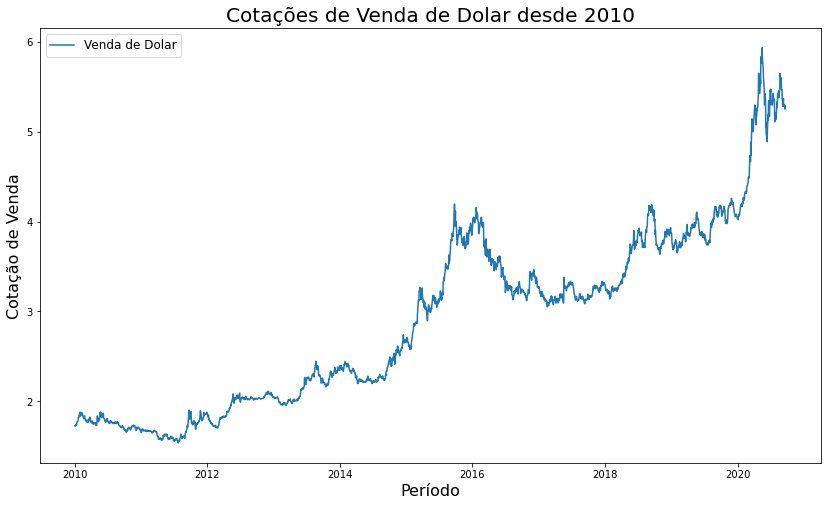

In [7]:
# filtrando janelas de tempo
#dados_pos = dados.loc[datetime.strptime("20200401", ""):,:]

# Exibindo série original
plt.plot(dados, label="Venda de %s"%moeda)
plt.title("Cotações de Venda de %s desde %d"%(moeda, ano_inicial), fontsize=20)
plt.xlabel("Período", fontsize=16)
plt.ylabel("Cotação de Venda", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [8]:
# função para decompor
def plotar_decomposicao(dados, decomp):
    tendencia = decomp.trend
    sazonalidade = decomp.seasonal
    residuos = decomp.resid
    plt.rcParams['figure.figsize']=(12,8)
    plt.subplot(411)
    plt.plot(dados, label="Original")
    plt.subplot(412)
    plt.plot(tendencia, label="Tendência")
    plt.subplot(413)
    plt.plot(sazonalidade, label="Sazonalidade")
    plt.subplot(414)
    plt.plot(residuos, label="Resíduos")
    plt.legend(loc="best")
    plt.tight_layout()

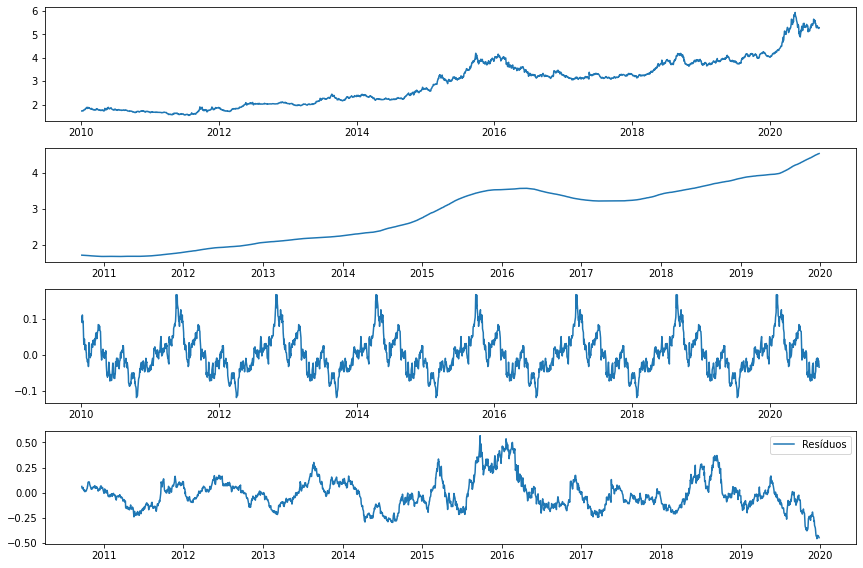

In [9]:
# Decomposição do modelo aditivo
decomposicao = seasonal_decompose(dados, model="aditive", freq=365)
plotar_decomposicao(dados.cotacao, decomposicao)

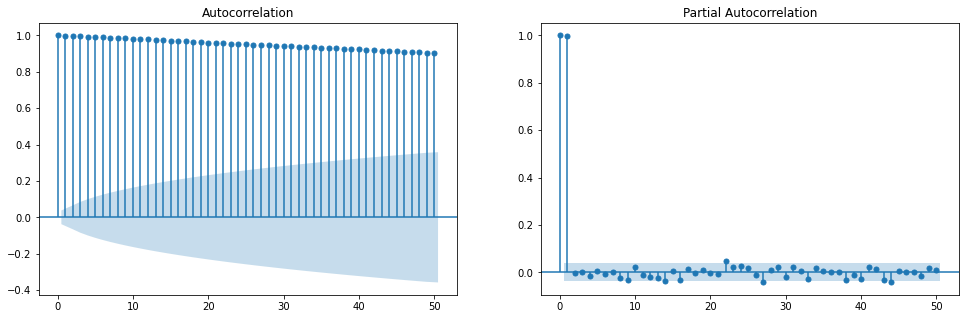

In [10]:
# Autocorrelação
def plotar_autocorrelacao(campo, lags=50):
    '''(np.array, int) -> None'''
    fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
    acf = plot_acf(campo, lags=lags, ax=ax[0])
    pacf = plot_pacf(campo, lags=lags, ax=ax[1])
    plt.show()
    
plotar_autocorrelacao(dados.cotacao)

## Estacionaridade
Na maioria dos testes de estacionaridade a hipótese nula é de que a série tenha raiz unitária, e portanto não seja estacionária, logo:

    H0: tem raiz unitária (não é estacionária)
    H1: não tem raiz unitária (é estacionária)

In [11]:
def teste_adfuller(campo):
    '''(str) -> None'''
    adfuller_test = adfuller(campo.dropna())
    print("P-valor do teste de Dickey-Fuller para a série: %.3f"%(adfuller_test[0]))
    if adfuller_test[0] < 0.05:
        print("Não vale H0 -> Série estacionária")
    else:
        print("Vale H0 -> Série não-estacionária")
    
teste_adfuller(dados.cotacao)

P-valor do teste de Dickey-Fuller para a série: 0.548
Vale H0 -> Série não-estacionária


## Diferenciação
Consiste em tomar sucessivas diferenças da série original até encontrar uma série estacionária:

  1. Primeira ordem: $ y_t = x_t - x_{t-1} = \nabla x_t $
  2. Segunda ordem:  $ y_t = \nabla^2 x_t = \nabla(x_t - x_{t-1}) = x_t - 2x_{t-1} + x_{t-2} $

In [36]:
dados.drop("cotacao_diff", axis=1, inplace=True)
dados["cotacao_diff"] = dados["cotacao"].diff()
dados.cotacao_diff.tail()

dia
2020-09-14    0.0130
2020-09-15   -0.0256
2020-09-16   -0.0196
2020-09-17    0.0061
2020-09-18    0.0296
Name: cotacao_diff, dtype: float64

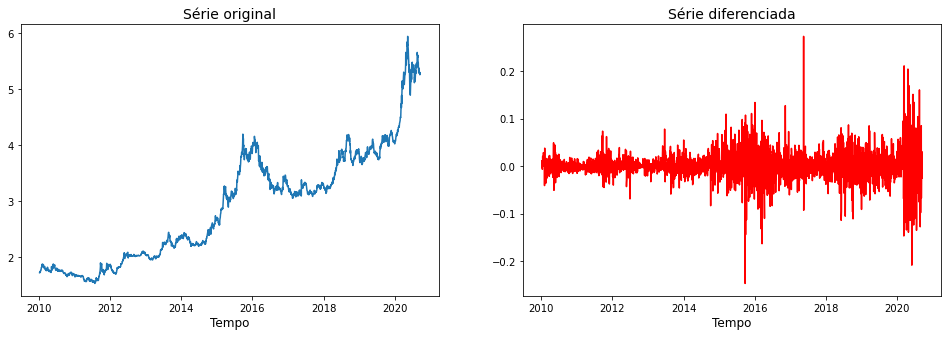

In [37]:
# série original
fig, ax = plt.subplots(1, 2, figsize=(16.5, 5))
ax[0].plot(dados.cotacao)
ax[0].set_title("Série original", fontsize=14)
ax[0].set_xlabel("Tempo", fontsize=12)

# série diferenciada
ax[1].plot(dados.cotacao_diff, color="red")
ax[1].set_title("Série diferenciada", fontsize=14)
ax[1].set_xlabel("Tempo", fontsize=12)
plt.show()

In [38]:
# testa estacionaridade para a serie diferenciada
teste_adfuller(dados.cotacao_diff)

P-valor do teste de Dickey-Fuller para a série: -10.264
Não vale H0 -> Série estacionária


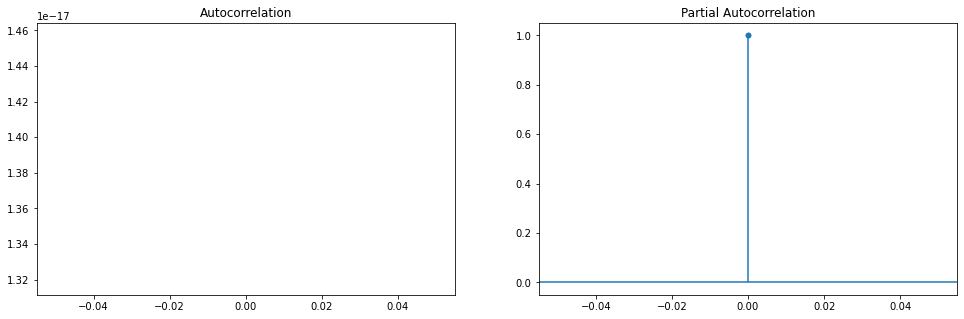

In [39]:
# autocorrelacao da serie diferenciada
plotar_autocorrelacao(dados.cotacao_diff)

## Treinamento
Treinar respeitando a ordenação temporal

    Validação: Treino | Teste |
    Previsão:  Treino         | Previsão

In [40]:
train_size = 0.90
train = dados.reset_index().loc[:np.round(dados.shape[0]*train_size), :]
test = dados.reset_index().loc[train.index.max()+1:, :]
train = train.set_index("dia")
test = test.set_index("dia")
# conferindo
print(train.index.max())
print(test.index.min())

2019-08-27 00:00:00
2019-08-28 00:00:00


In [41]:
def plotar_serie(train, test_x, test_y, label=""):
    seaborn.set_style({"axes.grid": False})
    fig, ax = plt.subplots(figsize=(14,7))
    ax.plot(train.index, train.cotacao, "b-")
    ax.set_ylim(1.0, 6.5)
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    ax2 = ax.twinx()
    ax2.plot(test_x, test_y, "r-.", label=label)
    ax2.set_ylim(1.0, 6.5)
    ax2.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

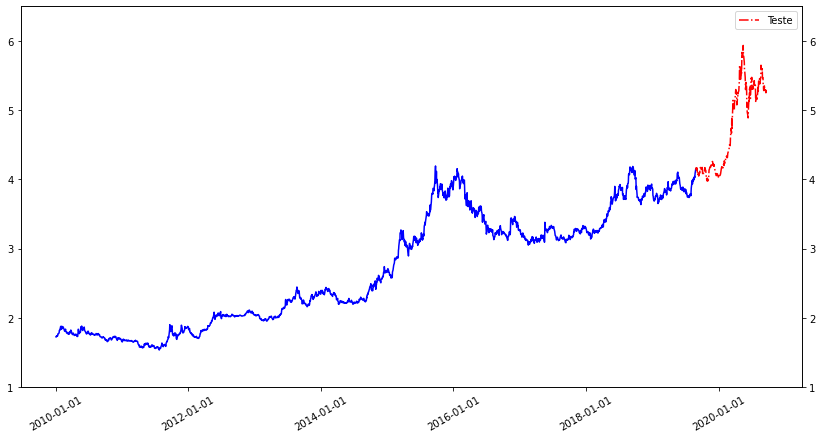

In [42]:
plotar_serie(train, test.index, test.cotacao, "Teste")

## Parâmetros do modelo

    *p é a ordem do componente autoregressiva
    *d é o número de diferenças tomadas na série
    *q é a ordem da componente de médias móveis

In [43]:
p = q = d = range(0, 10)
pdq = list(itertools.product(p, d, q))[1:] # ignorando (0, 0, 0)
#seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]
seasonal_pdq = [(0,0,0,1)]

In [45]:
# construindo uma busca de parâmetros ótimos
best_params, best_seasonal = None, None
best_aic = float("inf")
best_model = None

for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.cotacao, order=param)#, seasonal_order=param_seasonal)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal = param_seasonal
                best_model = mod
        except:
            continue
print("ARIMA%sx%s - AIC:%f"%(best_params, best_seasonal, best_aic))


ARIMA(1, 1, 6)x(0, 0, 0, 1) - AIC:-10760.552498


In [46]:
# fixando resultados
best_model = sm.tsa.statespace.SARIMAX(train.cotacao, order=best_params)#, seasonal_order=best_seasonal)
results = best_model.fit()
best_aic = results.aic

# exibe o melhor modelo em relação ao AIC
print("ARIMA%sx%s - AIC:%f"%(best_params, best_seasonal, best_aic))

ARIMA(1, 1, 6)x(0, 0, 0, 1) - AIC:-10760.552498


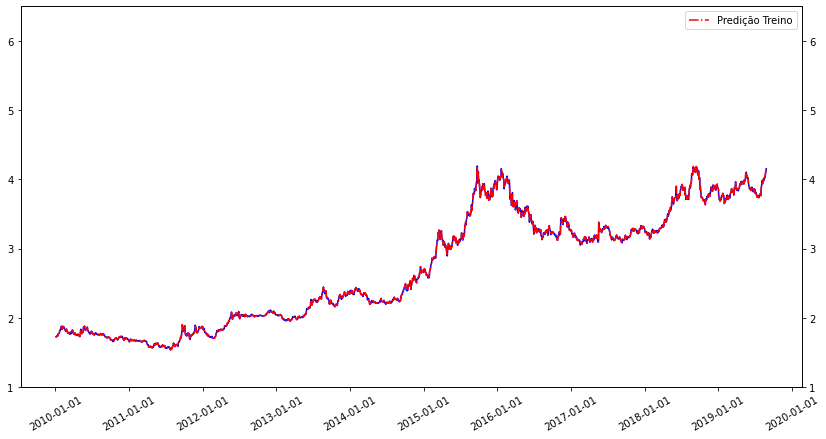

In [47]:
plotar_serie(train, train.index[:-1], results.fittedvalues[1:], "Predição Treino")

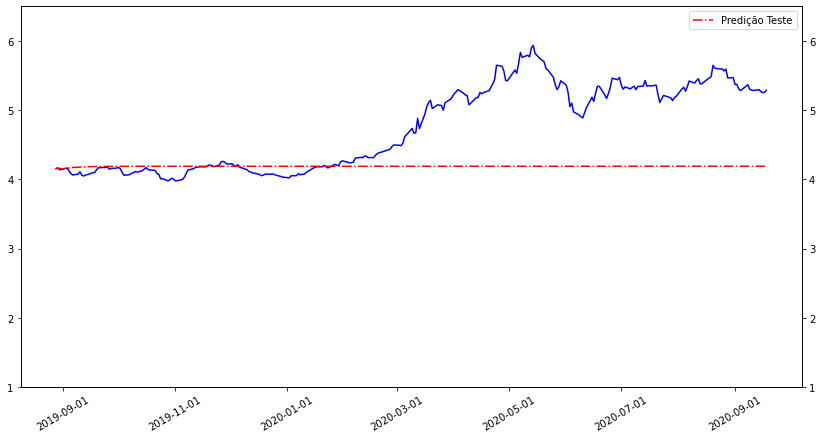

In [48]:
# Predição do conjunto de teste
pred_plot = results.forecast(test.shape[0], dynamic=True)
plotar_serie(test, test.index, pred_plot, "Predição Teste")

In [148]:
# Predição do futuro
#pred = results.forecast(start=test.index.min(), end=test.index.min()+timedelta(days=60), dynamic=True)

#np.datetime64(dados.reset_index().dia)

# vou tentar interpolar antes de tentar mais coisas aqui

dados.index

#plotar_serie(dados_pos, pred.index, pred, "Predição")

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-04', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18'],
              dtype='datetime64[ns]', name='dia', length=2692, freq=None)

## Analisando resíduos do modelo

In [ ]:
resid = results.resid.to_frame()
resid = resid.rename(columns={0: "resid"})
seaborn.set_style({"axes.grid" : True})

In [ ]:
# plotando os resíduos
fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(resid[1:])
plt.show()

In [ ]:
adfuller_res = adfuller(results.resid.dropna())
print("P-valor do teste de Dickey-Fuller para os resíduos: 0.3%"%(adfuller_res[1]))

In [ ]:
plotar_autocorrelacao(resid.dropna())